In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout


In [2]:
# load data
path = ''
df = pd.read_csv(path+"train.csv")


In [3]:
# a simple function to clean text data 
import re 
from string import punctuation 
def text_cleaning(text):
    # Clean the text data

    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
        
    # Return a list of words
    return(text)

In [4]:
#clean the train and test data
df["comment"] = df["comment"].apply(text_cleaning)


In [32]:
test = pd.read_csv(path+"test.csv")
test["comment"] = test["comment"].apply(text_cleaning)

In [6]:
X = df['comment']
y = df['sentiment'].to_numpy()

In [7]:
# Tokenize the comments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'])  
X = tokenizer.texts_to_sequences(df['comment']) 

# Pad the sequences 
max_sequence_length = 100  
X = pad_sequences(X, maxlen=max_sequence_length)

# Convert the sentiment labels to one-hot encoded vectors
y = np.zeros((len(df), 3))  # 3 represents the number of sentiment classes
sentiment_mapping = {-1: 0, 0: 1, 1: 2}  
for i, sentiment in enumerate(df['sentiment']):
    index = sentiment_mapping[sentiment]
    y[i, index] = 1


In [20]:
split_ratio = 0.75  # ~80% for training, 20% for testing
split_index = int(split_ratio * len(df))

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

In [21]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1706112   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 512)         788480    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,298,691
Trainable params: 3,298,691
Non-trainable params: 0
____________________________________________

The model used includes a bidirectional LSTM layer with 256 units, which is followed by another LSTM layer of the same size

In [22]:
history = model.fit(X_train, y_train, batch_size=32, epochs=4, validation_data=(X_test, y_test))

Epoch 1/4
74/74 [==============================] - 264s 3s/step - loss: 1.0014 - accuracy: 0.4919 - val_loss: 0.9407 - val_accuracy: 0.5634
Epoch 2/4
74/74 [==============================] - 277s 4s/step - loss: 0.7520 - accuracy: 0.7007 - val_loss: 0.9639 - val_accuracy: 0.5531
Epoch 3/4
74/74 [==============================] - 307s 4s/step - loss: 0.3250 - accuracy: 0.8843 - val_loss: 1.2477 - val_accuracy: 0.4904
Epoch 4/4
74/74 [==============================] - 285s 4s/step - loss: 0.1204 - accuracy: 0.9654 - val_loss: 1.6509 - val_accuracy: 0.4750


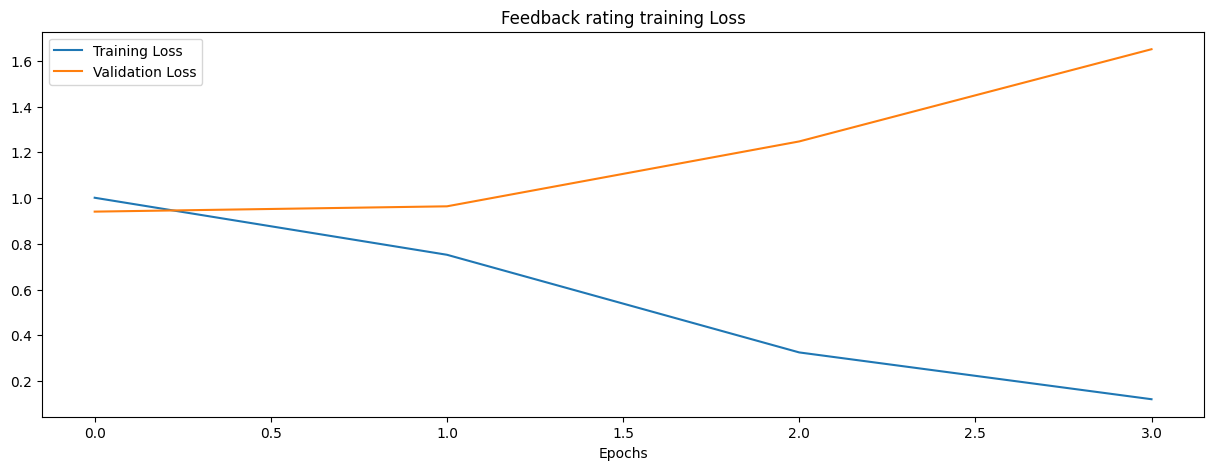

In [23]:
plt.figure(figsize=(15,5))
plt.title("Feedback rating training Loss")

plt.xlabel("Epochs")

x = history.epoch
plt.plot(x,history.history['loss'])
plt.plot(x,history.history['val_loss'])


plt.legend(["Training Loss", "Validation Loss"])

plt.show()

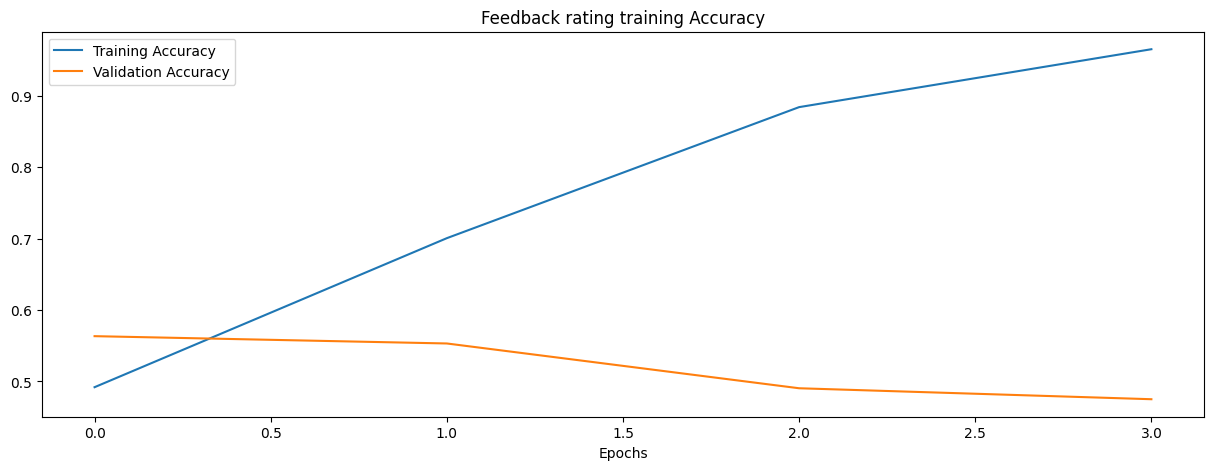

In [24]:
plt.figure(figsize=(15,5))
plt.title("Feedback rating training Accuracy")

plt.xlabel("Epochs")

x = history.epoch
plt.plot(x,history.history['accuracy'])
plt.plot(x,history.history['val_accuracy'])


plt.legend(["Training Accuracy", "Validation Accuracy"])

plt.show()

In [25]:
def predict_sentiment(sentence, tokenizer, model, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(sequence, verbose=0)
    # Convert the prediction probabilities to sentiment labels
    sentiment_labels = [-1, 0, 1]  
    predicted_sentiment = sentiment_labels[np.argmax(prediction)]
    return predicted_sentiment

In [26]:
sentiment_prediction = predict_sentiment(
    "Kabla hujatuma hela uwe unauliza namba ipi haina deni",
    tokenizer, 
    model, 
    max_sequence_length
)

In [27]:
sentiment_prediction

-1

In [28]:
# save the model
model.save("model/swahili_sentiment_rating_Bidirectional.h5")

#save tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizers/swahili_sentiment_rating_Bidirectional.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [33]:
# create complete submission dataframe
test['sentiment'] = test['comment'].apply(lambda x: predict_sentiment(x, tokenizer, model, max_sequence_length))

In [34]:
test[:20]

,test_id,comment,sentiment
0,53bb8dff-4a07-4aac-a6f2-ca552389652c,huduma1 wamenitext et wameniona mataa,0
1,a01e1c68-2f77-4073-87c5-d7e5d75c8a79,telecom1 tz telecom3tanzania na mtuue sasa,-1
2,9a5e4b98-ac29-4138-bc28-fc878d5d8269,hakuna mtandao wa simu unaoongoza kutuma messa...,0
3,9ef55f06-7748-4e02-85c7-fa3e46bb02dd,mwanzalimaa itakuwa kaipenda no yako kaenda k...,1
4,d93b4084-3000-4026-bae0-ecb65564dbbd,telecom1 tz mm ni wakala wa usajili wa lain c...,-1
5,5f8bdef9-225c-4bf7-bc09-e98caf404a9c,joyceline mk telecom2 hadi vifurushi vya daki...,0
6,5251826a-2476-42ad-9815-3840fcc3dd22,deoxz telecom1 tz mbona telecom2 wapo vzr ...,-1
7,54ac2429-6922-4648-b321-ef88ff583b18,reposted from cloudsmedialive nimekuja n...,-1
8,ceb8a1d6-1cee-46e6-9d18-9074c3a2c2d1,kumbe huduma1 deni lao unavyozidi kukaa nalo l...,0
9,61be8933-9e41-4633-ae57-f8f561447234,telecom1 tz vifurushi cya saizi yako ni motooooo,0


In [35]:
# drop column 'comment' from test and save to csv
test.drop(columns=['comment'], inplace=True)
test.to_csv("results/submission_v1__Bidirectional.csv", index=False)